In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import pathlib

In [3]:
# Format the image
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

# Load the data
(raw_train, raw_validation, raw_test), metadata = tfds.load('uc_merced', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    shuffle_files=True, with_info=True, as_supervised=True)

num_examples = metadata.splits['train'].num_examples  # Number of examples in dataset
num_classes = metadata.features['label'].num_classes  # Number of classes in dataset
print(num_examples," ",num_classes)

BATCH_SIZE = 32 # Feed in 32 images at a time

train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)  # Prefetch to increase latency
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1) # Prefetch to increase latency
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

2100   21


In [5]:
# Load the tensorflow model from tensorflow hub
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                    input_shape=IMAGE_SIZE + (3,),
                                    output_shape=[FV_SIZE],
                                    trainable=False)

print("Building model with", MODULE_HANDLE)

# define and instantiate your custom Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if( logs.get('accuracy') > 0.96 and epoch >= 15):
      self.model.stop_training = True
callbacks = myCallback()

# Build custom model 
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 20
hist = model.fit(train_batches, epochs=EPOCHS, validation_data = validation_batches, callbacks=[callbacks])

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 21)                26901     
Total params: 2,284,885
Trainable params: 26,901
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


53/53 [==============================] - 8s 83ms/step - loss: 1.4384 - accuracy: 0.6048 - val_loss: 0.4913 - val_accuracy: 0.8810
Epoch 2/20
53/53 [==============================] - 5s 76ms/step - loss: 0.3089 - accuracy: 0.9375 - val_loss: 0.2834 - val_accuracy: 0.9286
Epoch 3/20
53/53 [==============================] - 5s 76ms/step - loss: 0.1739 - accuracy: 0.9768 - val_loss: 0.2221 - val_accuracy: 0.9429
Epoch 4/20
53/53 [==============================] - 5s 76ms/step - loss: 0.1157 - accuracy: 0.9875 - val_loss: 0.1933 - val_accuracy: 0.9524
Epoch 5/20
53/53 [==============================] - 5s 76ms/step - loss: 0.0836 - accuracy: 0.9929 - val_loss: 0.1725 - val_accuracy: 0.9524
Epoch 6/20
53/53 [==============================] - 5s 78ms/step - loss: 0.0657 - accuracy: 0.9940 - val_loss: 0.1451 - val_accuracy: 0.9714
Epoch 7/20
53/53 [==============================] - 5s 77ms/step - loss: 0.0509 - accuracy: 0.9976 - val_loss: 0.1395 - val_accuracy: 0.9667
Epoch 8/20
53/53 [======

In [6]:
# Save the model
UC_MERCED_MODEL = "exp_saved_model"
tf.saved_model.save(model, UC_MERCED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [10]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(UC_MERCED_MODEL)

# Uncomment the below block of code to optimize with quantization aware training
'''converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for input_value, _ in test_batches.take(80):
    yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
'''
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)



2740624

In [23]:
class_names = [
    "agricultural",
    "airplane",
    "baseballdiamond",
    "beach",
    "buildings",
    "chaparral",
    "denseresidential",
    "forest",
    "freeway",
    "golfcourse",
    "harbor",
    "intersection",
    "mediumresidential",
    "mobilehomepark",
    "overpass",
    "parkinglot",
    "river",
    "runway",
    "sparseresidential",
    "storagetanks",
    "tenniscourt",
]

# Choose the model file 
tflite_model_file = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

score = 0
for item in range(0,99):
  prediction = np.argmax(predictions[item])
  label = test_labels[item]
  if prediction == label:
    score += 1

print("\nOut of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


Out of 100 predictions I got 93 correct


In [26]:
# Run this cell to upload images of your choosing. The images must be relevant to the class names mentioned above.
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = x /255.0
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  interpreter.set_tensor(input_index, image_tensor)
  interpreter.invoke()
  print('The image you selected is labeled as : ',class_names[np.argmax(interpreter.get_tensor(output_index))])


Saving external-content.duckduckgo.com.jpg to external-content.duckduckgo.com (1).jpg
[[[  3.  75.  89.]
  [  8.  77.  92.]
  [  5.  75.  87.]
  ...
  [236. 214. 200.]
  [233. 211. 197.]
  [240. 218. 204.]]

 [[  1.  73.  87.]
  [  0.  71.  85.]
  [  1.  71.  83.]
  ...
  [233. 211. 197.]
  [228. 206. 192.]
  [235. 213. 199.]]

 [[  0.  72.  86.]
  [  0.  71.  85.]
  [  1.  71.  83.]
  ...
  [229. 207. 193.]
  [230. 208. 194.]
  [235. 213. 199.]]

 ...

 [[  4.  53.  68.]
  [  3.  52.  67.]
  [  2.  51.  66.]
  ...
  [228. 202. 177.]
  [230. 206. 182.]
  [233. 209. 185.]]

 [[  0.  44.  60.]
  [  3.  50.  66.]
  [  3.  50.  66.]
  ...
  [229. 203. 178.]
  [227. 203. 179.]
  [238. 214. 190.]]

 [[ 16.  62.  78.]
  [  9.  55.  71.]
  [  6.  52.  68.]
  ...
  [236. 210. 185.]
  [235. 211. 187.]
  [238. 214. 190.]]]
The image you selected is labeled as :  beach


In [18]:
# Function to plot the images
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

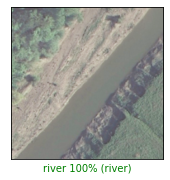

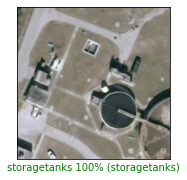

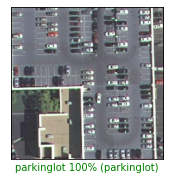

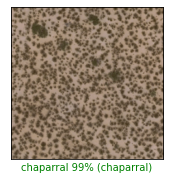

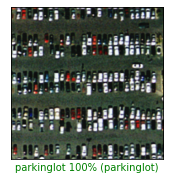

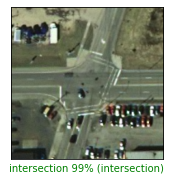

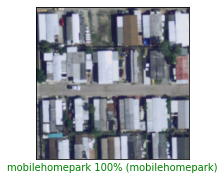

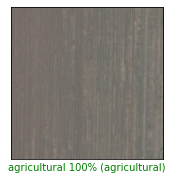

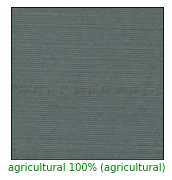

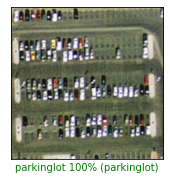

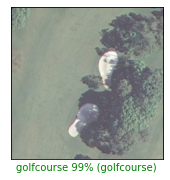

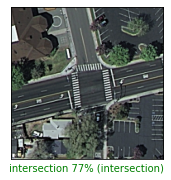

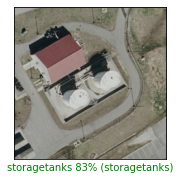

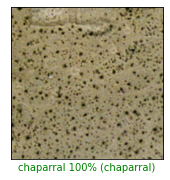

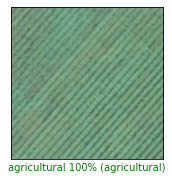

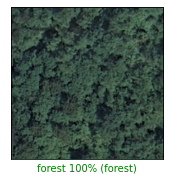

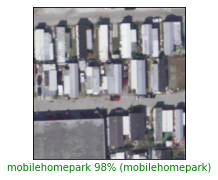

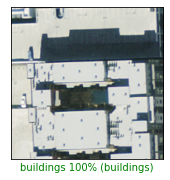

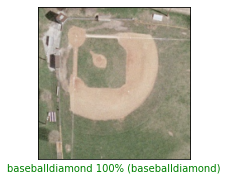

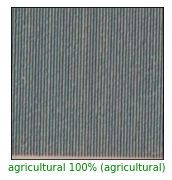

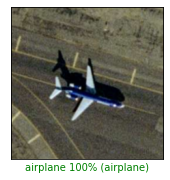

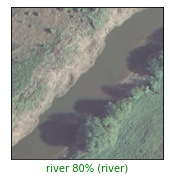

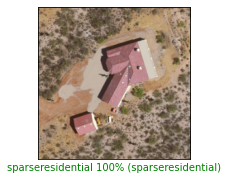

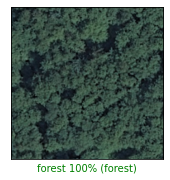

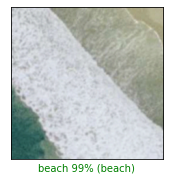

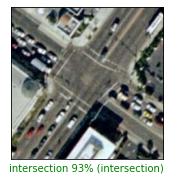

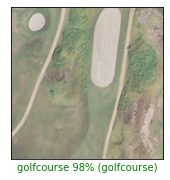

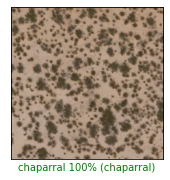

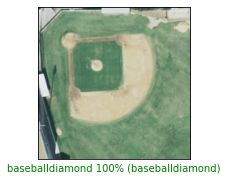

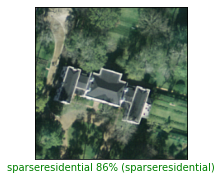

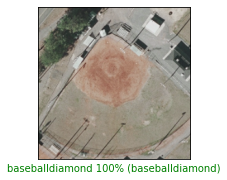

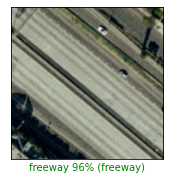

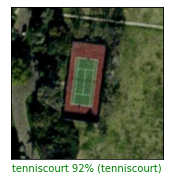

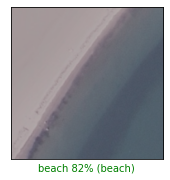

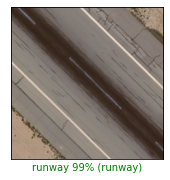

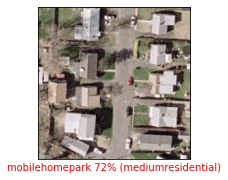

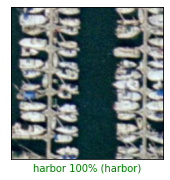

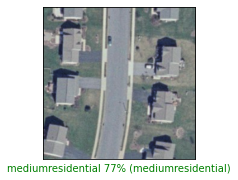

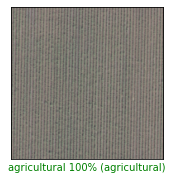

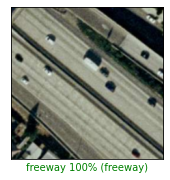

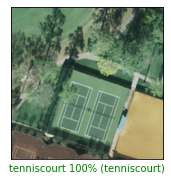

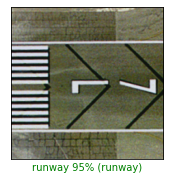

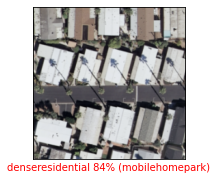

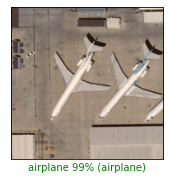

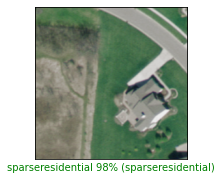

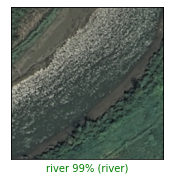

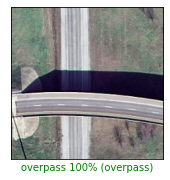

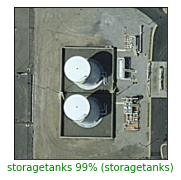

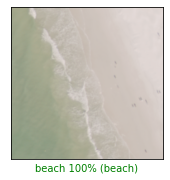

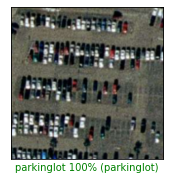

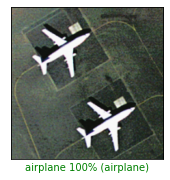

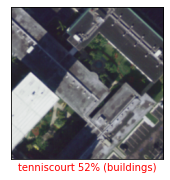

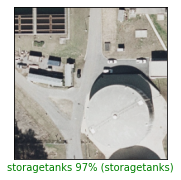

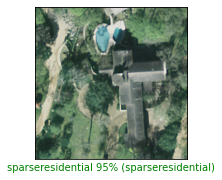

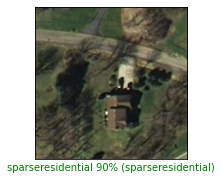

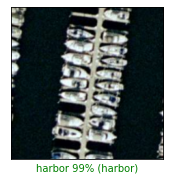

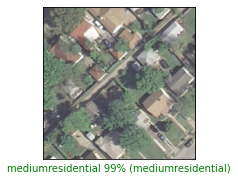

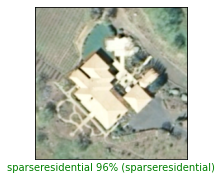

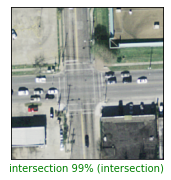

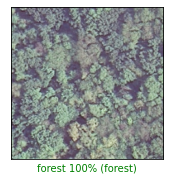

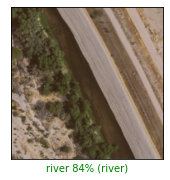

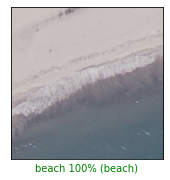

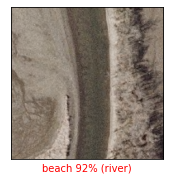

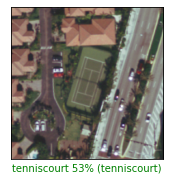

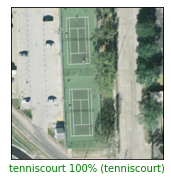

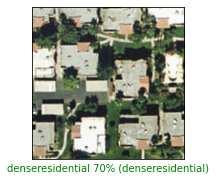

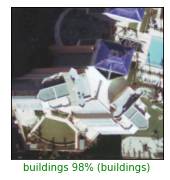

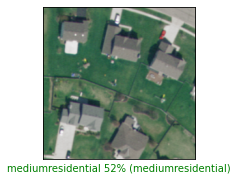

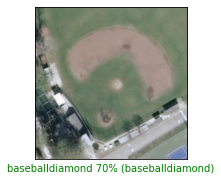

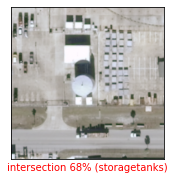

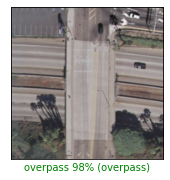

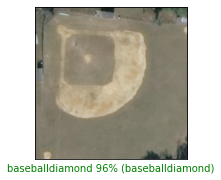

In [19]:
#@title Visualize the outputs each time { run: "auto" }
max_index = 72 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()